In [13]:
import copy
import itertools
from pprint import pprint
import warnings

import luigi
import dill
import pandas as pd
import numpy as np
from scipy import sparse

from experiment_framework.helpers import load_completed_CCCs_into_dataframe
from empirical_privacy.row_distributed_svd import AllSVDAsymptotics
from dataset_utils.common import load_dataset
from dataset_utils.recsys_datasets import get_ml1m_user
from dataset_utils.text_datasets import get_twenty_doc

from notebook_context import *

In [3]:
twenty_ng = load_dataset('20NG')
ml1m = load_dataset('ml-1m')

### Investigating a particular user


In [ ]:
warnings.simplefilter('ignore')  # pandas' warnings are not relevant to use

users={}
for i in range(5):
    users[i] = get_ml1m_user(i)

###### User #3 has the lowest accuracy for the classifier

In [ ]:
users[3]['User']

In [ ]:
users[3]['Ratings']

##### User #4 has the highest accuracy

In [ ]:
users[4]['User']

In [ ]:
users[4]['Ratings']

In [ ]:
for u in users:
    print(f"{u} rated {users[u]['Ratings'].shape[0]} movies")

So users who rate more than the average movies are easier to identify.

In [ ]:
X_ml1m = ml1m['Xtr']
user_nonzero, movie_nonzero = X_ml1m.nonzero()
def n_nonzero(user):
    return np.count_nonzero(user_nonzero==user)

In [ ]:
counts = pd.Series(user_nonzero).value_counts()

In [ ]:
counts.median()

## How about the 20NG text dataset?

For the 20NG text dataset rows are normalized to sum to 1, i.e. each document has the same 'weight' so we shouldn't see one document being easier to detect because it has a larger sum.

Doc #4 is much easier to identify than doc #3, why is that? Let's look at those documents.

### Doc#4

In [ ]:
doc=get_twenty_doc(4)
print(doc['text'])

In [ ]:
DF = pd.DataFrame.from_dict(
    [{'tfidf':s, 'word':w} for s,w in doc['words']]
)
print(DF.head().to_latex())

### Doc #3

In [ ]:
doc=get_twenty_doc(0)
print(doc['text'])
DF = pd.DataFrame.from_dict(
    [{'tfidf':s, 'word':w} for s,w in doc['words']]
)
print(DF.head().to_latex())

### Why do Eigenvalues reveal information on ML-1M but not 20NG

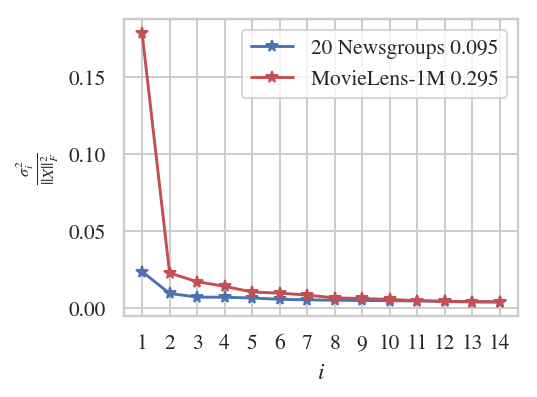

In [37]:
configure_plotting_for_publication()
k=14
xx = np.arange(1,k+1, 1)
U, Sigma, Vt = sparse.linalg.svds(twenty_ng['Xtr'], k=k)
yy_20ng = Sigma[::-1]**2 / sparse.linalg.norm(twenty_ng['Xtr'], 'fro')**2
plt.plot(xx, 
         yy_20ng,
         '-*b')

U, Sigma, Vt = sparse.linalg.svds(ml1m['Xtr'].astype('f'), k=k)
yy_ml1m = Sigma[::-1]**2 / sparse.linalg.norm(ml1m['Xtr'], 'fro')**2
plt.plot(xx,
         yy_ml1m,
         '-*r')

plt.xticks(xx)
plt.xlabel('$i$')
plt.ylabel('$\\frac{\sigma_i^2}{||X||_F^2}$')
plt.legend(['20 Newsgroups {:.3f}'.format(np.sum(yy_20ng)),
            'MovieLens-1M {:.3f}'.format(np.sum(yy_ml1m))])

if SAVE_FIGURES_FOR_LATEX:
    plt.tight_layout()
    plt.savefig(join(FIGURES_PATH, 'experiment4_spectrum.eps'))